# Problem Statement

Recent complaints of late orders by customers has raised concern of courier punctuality, compliance and productuvity.

**Objective:** Evaluate and quantify the prevalence of the problem.

**LINK TO SLIDE PRESENTATION:** https://drive.google.com/file/d/1PUuD9m_xDV92olhrZBOb91fndXeQ4NXf/view?usp=sharing

### KPI DEFINITIONS:

1. **Order Completion Rate**<br>
Order Completion Rate measures general effectiveness in satisfying client order requests by looking at the percentage of all orders that were delivered successfully in a given day.

$$\frac{total\ orders\ delivered}{total\ orders}$$
2. **On-Time Delivery Adherence**<br>
OTDA refers to the percentage of orders that were delivered within the scheduled timeframe. A critical metric that underpins Paacks commitment to customer controlled timeslots for deliveries.

$$\frac{total\ orders\ on\ time}{total\ orders}$$<br>
$$ (total\ orders\ on\ time = total\ orders\ delivered - total\ late\ orders) $$
3. **Driver On-Time Efficiency**<br>
How efficiently is the front-line operating? This metric aims to parse at the performance of the front-line unit by understanding if efficiency is a systemic or localized (per courier) issue. It is summarized by the percent of drivers who had at least one late order during the day.

$$\frac{number\ of\ drivers\ with\ at\ least\ one\ late\ order}{total\ number\ of\ drivers}$$
4. **Average Productivity**<br>
Another efficiency metric to understand the current capacity of each front-line driver and performance to capacity targets. It is the average number of orders attempted per hour.

$$AVG(\sum_{}\frac{number\ of\ orders\ attempted}{total\ hours}\ per\ driver)$$

#### Import & Clean Dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
file = 'drivers_summary.csv'

df = pd.read_csv(file, sep=';')

print(df.shape)
df.head()

(100, 10)


,driver,parcels delivered,orders delivered,orders failed,orders attempted,orders to deliver,orders delayed,orders early,start time,end time (last delivery attempt)
0,Adolph Nottingham,77,71,0,71,0,0,0,11:21:58,16:27:01
1,Agnes Simmons,4,1,0,1,0,0,0,18:23:43,18:44:45
2,Alena Stangl,36,36,3,39,0,0,10,8:34:33,13:03:39
3,Alleen Domina,52,52,4,56,0,0,0,11:29:06,18:01:10
4,Amie Grigsby,55,10,0,10,0,0,2,12:50:45,18:27:24


In [3]:
#rename last col for easier manipulation
df.rename(columns={'end time (last delivery attempt)':'end time lda'}, inplace=True)

#update dtypes
df[['start time', 'end time lda']] = df[['start time', 'end time lda']].astype('datetime64')

In [4]:
#check for duplicate records
df.duplicated().any()

False

In [5]:
#check for null values
df.isnull().any()

driver               False
parcels delivered    False
orders delivered     False
orders failed        False
orders attempted     False
orders to deliver    False
orders delayed       False
orders early         False
start time           False
end time lda         False
dtype: bool

#### ANALYSIS

**Definitions & Assumptions:**<br>
- Orders to deliver are outstanding orders that have yet to be attempted
- Orders delayed are orders that were delivered but outside of the scheduled timewindow

- Total Orders is the sum of attempted orders and orders to deliver<br>
- Total Late is the sum of orders failed + orders to deliver + orders delayed

In [6]:
#Create total orders column. Total Orders = Orders attempted + Orders to Deliver (still open)
df['total orders'] = df.iloc[:, 4:6].sum(axis=1)

#Total orders not received on time
df['total late'] = df[['orders failed', 'orders to deliver', 'orders delayed']].sum(axis=1)

In [7]:
#return series of all fields aggregated for the day
df_agg = df.sum(numeric_only=True)

df_agg

parcels delivered    4172
orders delivered     3342
orders failed         294
orders attempted     3636
orders to deliver      24
orders delayed         33
orders early          202
total orders         3660
total late            351
dtype: int64

#### 1. Order Completion Rate 

In [8]:
pct_comp = df['orders delivered'].sum() / df['total orders'].sum()

print(f'{pct_comp:.2%} of orders were completed meaning {1-pct_comp:.2%} of orders were not.')

91.31% of orders were completed meaning 8.69% of orders were not.


#### 2. On-Time Delivery Adherence
Some orders delivered could have been delayed & others might have failed or yet to be delivered (still open order). These all classify as late deliveries.

In [9]:
# (df_agg['orders attempted'] - df_agg[['orders failed', 'orders delayed']].sum()) / df_agg['orders attempted']

In [10]:
pct_ontime = (df_agg['total orders'] - df_agg[['orders failed', 'orders delayed', 'orders to deliver']].sum()) / df_agg['total orders']

print('{:.2%} of orders were delivered on time, meaning {} out of {} of all orders were delayed for some reason.'.format(pct_ontime, df_agg['total late'], df_agg['total orders'] ) )
# print(round((1-pct_ontime), 4))

90.41% of orders were delivered on time, meaning 351 out of 3660 of all orders were delayed for some reason.


In [84]:
#Delivery adherence by each late category
for i, v in df_agg[['orders failed', 'orders delayed', 'orders to deliver']].items():
    print(i, ':', v*100 / df_agg['total late'])
    print(str(v) + ' total')

orders failed : 83.76068376068376
294 total
orders delayed : 9.401709401709402
33 total
orders to deliver : 6.837606837606837
24 total


#### 3. Driver On-Time Efficiency

In [12]:
#Create dummy bool, 1 if delayed 0 if not
df['delay'] = np.where(df['total late'] >= 1, 1, 0)

In [13]:
#Count number of instances in each delay category
drive_time = df['delay'].value_counts(normalize=True)

print(f'Percent of drivers with at least one late order today was {drive_time[1]:.1%} ')

Percent of drivers with at least one late order today was 56.0% 


In [14]:
#Total num of couriers delayed
df['delay'].sum()

56

Quick investigation of distribution among 10 less efficient drivers

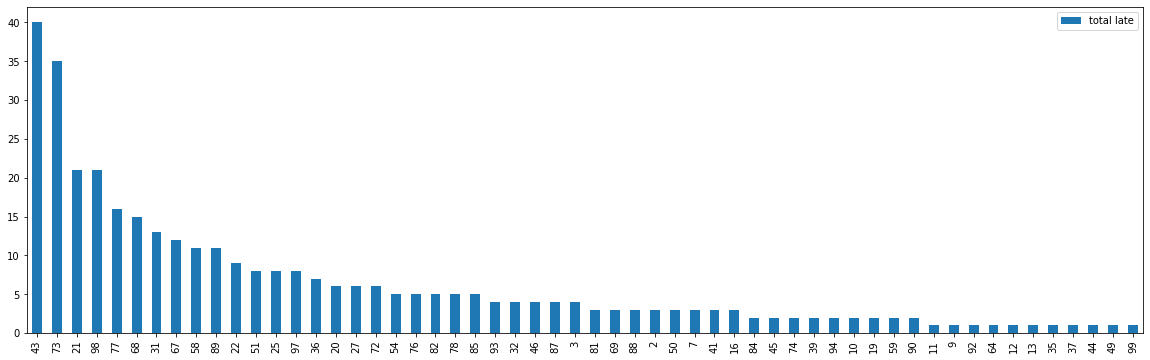

In [15]:
#Group by delayed category
delay_grp = df.groupby('delay').get_group(1)

#return new df of total late orders by driver
late_drivers = delay_grp[['driver', 'total late']].sort_values('total late', ascending=False)

#quick view of distribution of drivers
late_drivers.plot(kind='bar', figsize=(20,6))

In [16]:
late_drivers['total late'].head(10).sum()

195

#### 4. Average Productivity

In [72]:
#total hours in minutes per driver
df['hours'] = (df['end time lda'] - df['start time']).dt.total_seconds() / 3600

#orders attempted per hour per driver
df['productivity'] = df['orders attempted'] / df['hours']

In [73]:
#Calculate average orders attempted per hour
np.average(df['productivity'])

7.768326059448916

In [83]:
#Average number of parcels per delivery
np.average(df['parcels delivered'] / df['orders delivered'])

2.209191622499615